In [ ]:
'''
Assignment 6: Anomaly Detection Using Autoencoders 
Goal: Use an autoencoder to detect anomalies in tabular time series or sensor data. 
Dataset: NAB (Numenta Anomaly Benchmark) or Credit Card Fraud Dataset 
 NAB: https://github.com/numenta/NAB 
 Credit Card: https://www.kaggle.com/mlg-ulb/creditcardfraud 
� Task: 
Students will train an autoencoder only on normal (non-fraudulent or non-anomalous) data. 
At test time, high reconstruction error will indicate potential anomalies. 
Assignment Steps: 
1. Load the dataset and separate normal and anomalous data. 
2. Normalize the features. 
3. Build a deep autoencoder suitable for tabular data. 
4. Train only on the normal samples. 
5. Compute reconstruction error on both normal and anomalous data. 
6. Evaluate: 
o Plot reconstruction error histograms. 
o Use precision, recall, F1-score for anomaly detection. 
o Choose a threshold for classifying anomalies. 
7. Bonus: Plot ROC curve and compute AUC. 
Learning Outcomes: 
 Apply unsupervised learning to real-world anomaly detection. 
 Understand how reconstruction loss can indicate outliers. 
 Use evaluation metrics for imbalanced classification. 
'''

In [27]:
import pandas as pd

# URLs for the NAB series (raw CSV files on GitHub)
base_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
train_url = base_url + "artificialNoAnomaly/art_daily_small_noise.csv"
test_url  = base_url + "artificialWithAnomaly/art_daily_jumpsup.csv"

# Load as pandas DataFrames, parse timestamp
df_train = pd.read_csv(train_url, parse_dates=['timestamp'], index_col='timestamp')
df_test  = pd.read_csv(test_url,  parse_dates=['timestamp'], index_col='timestamp')

# Quick preview of the data
print(df_train.head())
print(df_test.head())


                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


In [28]:
import numpy as np

# Split training data into train/validation (80/20 split)
train_size = int(len(df_train) * 0.8)
df_train_train = df_train.iloc[:train_size]
df_train_val   = df_train.iloc[train_size:]

# Compute normalization parameters from the training split
mu = df_train_train.mean()
sigma = df_train_train.std()

# Apply normalization
train_norm = (df_train_train - mu) / sigma
val_norm   = (df_train_val   - mu) / sigma
test_norm  = (df_test        - mu) / sigma  # normalize test using training stats

# Function to create sliding-window sequences
def create_sequences(data, time_steps=288):
    """
    Returns an array of shape (n_samples, time_steps) from a 1-D array.
    """
    values = data.values.flatten()
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i:(i + time_steps)])
    return np.array(output)

# Create sequences for training, validation, and test (anomalous data)
TIME_STEPS = 288
x_train = create_sequences(train_norm, TIME_STEPS)
x_val   = create_sequences(val_norm,   TIME_STEPS)
x_test  = create_sequences(test_norm,  TIME_STEPS)

print("Train sequences:", x_train.shape)
print("Validation sequences:", x_val.shape)
print("Test sequences (with anomaly):", x_test.shape)


Train sequences: (2938, 288)
Validation sequences: (520, 288)
Test sequences (with anomaly): (3745, 288)


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define autoencoder architecture
input_dim = x_train.shape[1]  # 288
encoding_dim1 = 128
encoding_dim2 = 64
encoding_dim3 = 32

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(encoding_dim1, activation='relu'),
    layers.Dense(encoding_dim2, activation='relu'),
    layers.Dense(encoding_dim3, activation='relu'),   # bottleneck
    layers.Dense(encoding_dim2, activation='relu'),
    layers.Dense(encoding_dim1, activation='relu'),
    layers.Dense(input_dim,    activation='linear')  # reconstruct original dimension
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 288)                 │          37,152 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,912 (370.75 KB)

 Trainable params: 94,912 (370.75 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the autoencoder
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_val, x_val)
)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0243 - val_loss: 0.0226
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0241 - val_loss: 0.0224
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 - val_loss: 0.0222
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0238 - val_loss: 0.0221
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0237 - val_loss: 0.0221
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - val_loss: 0.0219
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0236 - val_loss: 0.0219
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234 - val_loss: 0.0218
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234 - val_loss: 0.0216
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0233 - val_loss: 0.0215
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0231 - val_loss: 0.0213
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0230 - val_lo

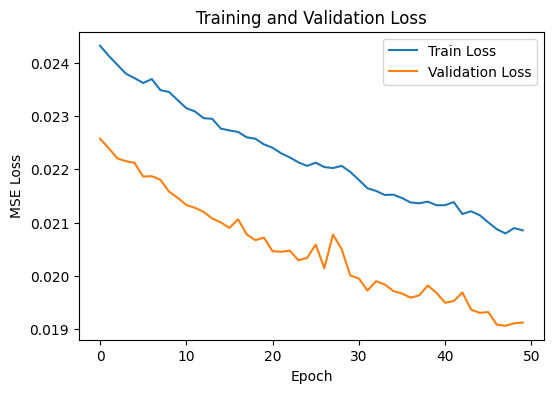

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [33]:
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report

# Compute reconstructions and errors
x_val_pred  = autoencoder.predict(x_val)
x_test_pred = autoencoder.predict(x_test)

# Mean Squared Error per sequence
mse_val  = np.mean(np.square(x_val - x_val_pred), axis=1)
mse_test = np.mean(np.square(x_test - x_test_pred), axis=1)

# Combine errors and labels (0=normal, 1=anomaly)
errors = np.concatenate([mse_val, mse_test])
labels = np.concatenate([np.zeros(len(mse_val)), np.ones(len(mse_test))])


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Chosen threshold: 0.0226


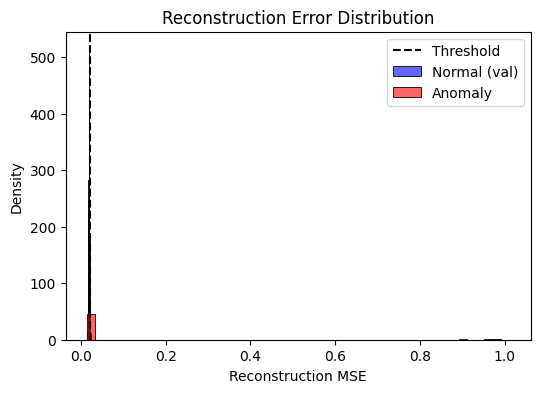

In [34]:
import seaborn as sns

threshold = mse_val.mean() + 3 * mse_val.std()
print(f"Chosen threshold: {threshold:.4f}")

# Plot histogram of reconstruction errors
plt.figure(figsize=(6,4))
sns.histplot(mse_val, color='blue', label='Normal (val)', bins=50, stat='density', alpha=0.6)
sns.histplot(mse_test, color='red',  label='Anomaly', bins=50, stat='density', alpha=0.6)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction MSE')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()


              precision    recall  f1-score   support

      Normal       0.15      0.99      0.26       520
     Anomaly       1.00      0.23      0.37      3745

    accuracy                           0.32      4265
   macro avg       0.57      0.61      0.32      4265
weighted avg       0.89      0.32      0.36      4265

AUC: 0.682


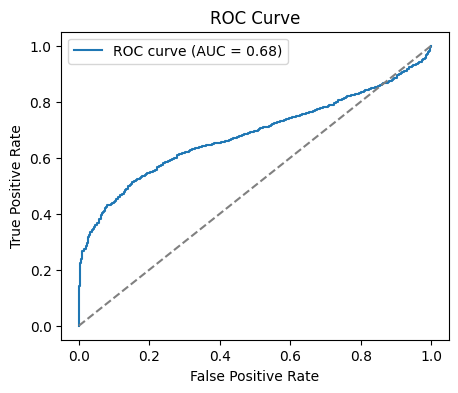

In [35]:
# Classify using the threshold
y_pred = (errors > threshold).astype(int)

# Print precision, recall, F1-score
print(classification_report(labels, y_pred, target_names=['Normal','Anomaly']))

# Compute ROC and AUC
fpr, tpr, _ = roc_curve(labels, errors)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

# Plot ROC curve
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
